In [1]:
# Project Goal: Using the available data from yelp, build a prediction model to predict which businesses will start doing delivery/takeout after the first lockdown.

# Team Members:
#    FANG Anbing
#    LAGO Jenie Marie
#    YANG Zhou

In [2]:
# Set all necessary sources here
path_covid_features = "/Users/jenielago/Documents/Class/BDT/BDT2 Group/yelp2/parsed_covid_sample.json"
path_yelp_business = "/Users/jenielago/Documents/Class/BDT/BDT2 Group/yelp2/parsed_business_sample.json"
path_yelp_checkin = "/Users/jenielago/Documents/Class/BDT/BDT2 Group/yelp2/parsed_checkin_sample.json"
path_yelp_review = "/Users/jenielago/Documents/Class/BDT/BDT2 Group/yelp2/parsed_review_sample.json"
path_yelp_tip = "/Users/jenielago/Documents/Class/BDT/BDT2 Group/yelp2/parsed_tip_sample.json"
path_yelp_user = "/Users/jenielago/Documents/Class/BDT/BDT2 Group/yelp2/parsed_user_sample.json"

In [3]:
# For using pyspark in local computer with jupyter notebook
# Comment if using Databricks
from pyspark import SparkContext, SparkConf

from pyspark.sql import SQLContext

conf = SparkConf().setAppName("PySpark App").setMaster("local[2]")
conf.set("spark.executor.memory", "8g")
conf.set("spark.driver.memory", "8g")
conf.set("spark.cores.max", "2")

sc = SparkContext.getOrCreate(conf=conf)
spark = SQLContext(sc)
spark.sql("set spark.sql.shuffle.partitions=2")

DataFrame[key: string, value: string]

In [4]:
# Imports
from pyspark.sql.functions import count
from pyspark.sql.types import StructField, StructType, StringType, BooleanType
from pyspark.sql.functions import isnan, when, count, col, lower, when, to_timestamp, array_contains
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [5]:
# Load the json file
df_covid_features = spark.read.format("json")\
  .option("inferSchema","true")\
  .load(path_covid_features)

In [6]:
# Reference: https://www.yelp.com/dataset/documentation/main
df_covid_features.printSchema()

root
 |-- Call To Action enabled: string (nullable = true)
 |-- Covid Banner: string (nullable = true)
 |-- Grubhub enabled: string (nullable = true)
 |-- Request a Quote Enabled: string (nullable = true)
 |-- Temporary Closed Until: string (nullable = true)
 |-- Virtual Services Offered: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- delivery or takeout: string (nullable = true)
 |-- highlights: string (nullable = true)



In [7]:
# Get shape of dataframe
print((df_covid_features.count(), len(df_covid_features.columns)))

(19053, 9)


In [8]:
# Check the number of unique business IDs
df_covid_features.select('business_id').distinct().count()

19018

In [9]:
# Drop duplicates
df_covid_features = df_covid_features.dropDuplicates(['business_id'])
df_covid_features.select('business_id').distinct().count()

19018

In [10]:
df_covid_features.show(3)

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
|Call To Action enabled|Covid Banner|Grubhub enabled|Request a Quote Enabled|Temporary Closed Until|Virtual Services Offered|         business_id|delivery or takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
|                  TRUE|       FALSE|          FALSE|                  FALSE|                 FALSE|                   FALSE|-0LPtgJC31FWMrMv3...|              FALSE|     FALSE|
|                 FALSE|       FALSE|          FALSE|                  FALSE|                 FALSE|                   FALSE|-1MVd6ljY2JT6gCKn...|              FALSE|     FALSE|
|                 FALSE|       FALSE|          FALSE|                  FALSE|                 FALSE|          

In [11]:
# Count the number of nulls per column
df_covid_features.select([count(when(col(c).isNull(), c)).alias(c) for c in df_covid_features.columns]).show()

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
|Call To Action enabled|Covid Banner|Grubhub enabled|Request a Quote Enabled|Temporary Closed Until|Virtual Services Offered|business_id|delivery or takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
|                     0|           0|              0|                      0|                     0|                       0|          0|                  0|         0|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+



In [12]:
# Rename all the columns, remove spaces for easier calling in the next steps
df_covid_features = df_covid_features.select([col(c).alias(c.replace(' ', '_')) for c in df_covid_features.columns])

In [13]:
# Reload View
df_covid_features.createOrReplaceTempView("df_covid_features")

In [14]:
# Inspect columns that do not look boolean
spark.sql("""
  select distinct Covid_Banner
          from df_covid_features
""").show(5)

+--------------------+
|        Covid_Banner|
+--------------------+
|               FALSE|
|We are open for a...|
|As a preventative...|
|April 29th, 2020 ...|
|Our team is avail...|
+--------------------+
only showing top 5 rows



In [15]:
spark.sql("""
  select distinct Temporary_Closed_Until
          from df_covid_features
""").show(5, truncate = False)

+------------------------+
|Temporary_Closed_Until  |
+------------------------+
|FALSE                   |
|2020-08-01T00:00:00.000Z|
|2020-06-15T00:00:00.000Z|
|2020-10-01T00:00:00.000Z|
|2020-11-01T00:00:00.000Z|
+------------------------+
only showing top 5 rows



In [16]:
spark.sql("""
  select distinct Virtual_Services_Offered
          from df_covid_features
""").show(15, truncate = False)

+-------------------------------+
|Virtual_Services_Offered       |
+-------------------------------+
|FALSE                          |
|offers_virtual_classes         |
|offers_virtual_tours           |
|offers_virtual_consultations   |
|offers_virtual_performances    |
|offers_virtual_tasting_sessions|
|offers_virtual_experiences     |
+-------------------------------+



In [17]:
spark.sql("""
  select distinct highlights
          from df_covid_features
""").show(5, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|highlights                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|FALSE                                                                                                                                                    

In [18]:
# change to lower case the columns identified as boolean
df_covid_features = df_covid_features.withColumn("Call_To_Action_enabled",lower(col("Call_To_Action_enabled")))\
                      .withColumn("Grubhub_enabled",lower(col("Grubhub_enabled")))\
                      .withColumn("Request_a_Quote_Enabled",lower(col("Request_a_Quote_Enabled")))\
                      .withColumn("delivery_or_takeout",lower(col("delivery_or_takeout")))

df_covid_features.show(5)

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
|Call_To_Action_enabled|Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered|         business_id|delivery_or_takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+
|                  true|       FALSE|          false|                  false|                 FALSE|                   FALSE|-0LPtgJC31FWMrMv3...|              false|     FALSE|
|                 false|       FALSE|          false|                  false|                 FALSE|                   FALSE|-1MVd6ljY2JT6gCKn...|              false|     FALSE|
|                 false|       FALSE|          false|                  false|                 FALSE|          

In [19]:
df_covid_features = df_covid_features.withColumn("Call_To_Action_enabled",col("Call_To_Action_enabled").cast(BooleanType()))\
    .withColumn("Grubhub_enabled",col("Grubhub_enabled").cast(BooleanType())) \
    .withColumn("Request_a_Quote_Enabled",col("Request_a_Quote_Enabled").cast(BooleanType())) \
    .withColumn("delivery_or_takeout",col("delivery_or_takeout").cast(BooleanType()))

In [20]:
# Count the number of nulls per column, check if cast of all columns successful
df_covid_features.select([count(when(col(c).isNull(), c)).alias(c) for c in df_covid_features.columns]).show()

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
|Call_To_Action_enabled|Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered|business_id|delivery_or_takeout|highlights|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+
|                     0|           0|              0|                      0|                     0|                       0|          0|                  0|         0|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+-----------+-------------------+----------+



In [21]:
# Create _isWithText for the string columns, it was noticed that some columns have FALSE and string values with them. Create a flag for businesses who actually filled out said columns
cols_string = ["Covid_Banner", "Temporary_Closed_Until", "Virtual_Services_Offered", "highlights"]

for col_name in cols_string:
  col_name_new = col_name + "_withText"
  df_covid_features = df_covid_features.withColumn(col_name_new, when(col(col_name)== 'FALSE', 0).otherwise(1))

In [22]:
# Check values of those columns with actual text
df_covid_features.filter(df_covid_features.Virtual_Services_Offered_withText == 1).show(5)

+----------------------+--------------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+
|Call_To_Action_enabled|        Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered|         business_id|delivery_or_takeout|          highlights|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|
+----------------------+--------------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+
|                  true|As a preventative...|          false|                  false|  2

In [23]:
# String indexer for Virtual_Services_Offered
lblIndxr = StringIndexer().setInputCol("Virtual_Services_Offered").setOutputCol("VSOInd")

# Perform OneHotEncoding for the Virtual_Services_Offered column
ohee_catv = OneHotEncoder().setInputCol("VSOInd").setOutputCol("VSO_dum")

# Pipeline
pipe_catv = Pipeline(stages=[lblIndxr, ohee_catv])

In [24]:
df_covid_features = pipe_catv.fit(df_covid_features).transform(df_covid_features)
df_covid_features = df_covid_features.drop("VSOInd")
df_covid_features.show(3)

+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
|Call_To_Action_enabled|Covid_Banner|Grubhub_enabled|Request_a_Quote_Enabled|Temporary_Closed_Until|Virtual_Services_Offered|         business_id|delivery_or_takeout|highlights|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|      VSO_dum|
+----------------------+------------+---------------+-----------------------+----------------------+------------------------+--------------------+-------------------+----------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
|                  true|       FALSE|          false|                  false|                 FALSE|

In [25]:
# Drop some string columns, To-DO: In the future we can analyze the content of the strings
drop_cols = cols_string

df_covid_features = df_covid_features.drop(*drop_cols)
df_covid_features.printSchema()

root
 |-- Call_To_Action_enabled: boolean (nullable = true)
 |-- Grubhub_enabled: boolean (nullable = true)
 |-- Request_a_Quote_Enabled: boolean (nullable = true)
 |-- business_id: string (nullable = true)
 |-- delivery_or_takeout: boolean (nullable = true)
 |-- Covid_Banner_withText: integer (nullable = false)
 |-- Temporary_Closed_Until_withText: integer (nullable = false)
 |-- Virtual_Services_Offered_withText: integer (nullable = false)
 |-- highlights_withText: integer (nullable = false)
 |-- VSO_dum: vector (nullable = true)



In [26]:
df_covid_features.groupBy("delivery_or_takeout").count().show()

+-------------------+-----+
|delivery_or_takeout|count|
+-------------------+-----+
|              false|12794|
|               true| 6224|
+-------------------+-----+



In [27]:
# Update sql view
df_covid_features.createOrReplaceTempView("df_covid_features")

In [28]:
df_covid_features.show(5)

+----------------------+---------------+-----------------------+--------------------+-------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|         business_id|delivery_or_takeout|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|      VSO_dum|
+----------------------+---------------+-----------------------+--------------------+-------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+
|                  true|          false|                  false|-0LPtgJC31FWMrMv3...|              false|                    0|                              0|                                0|                  0|(6,[0],[1.0])|
|                 false|          false|                  false|-1MVd6ljY2JT6gCKn...|   

In [29]:
df_covid_features = df_covid_features.withColumn("label",col("delivery_or_takeout").cast("double")).drop("delivery_or_takeout")
df_covid_features = df_covid_features.withColumn("Grubhub_enabled",col("Grubhub_enabled").cast("double"))
df_covid_features = df_covid_features.withColumn("Request_a_Quote_Enabled",col("Request_a_Quote_Enabled").cast("double"))
df_covid_features = df_covid_features.withColumn("Request_a_Quote_Enabled",col("Request_a_Quote_Enabled").cast("double"))
df_covid_features = df_covid_features.withColumn("Call_To_Action_enabled",col("Call_To_Action_enabled").cast("double"))

In [30]:
df_covid_features.show(5)

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|         business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|      VSO_dum|label|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+
|                   1.0|            0.0|                    0.0|-0LPtgJC31FWMrMv3...|                    0|                              0|                                0|                  0|(6,[0],[1.0])|  0.0|
|                   0.0|            0.0|                    0.0|-1MVd6ljY2JT6gCKn...|                    0|                              0|     

In [31]:
df_covid_features.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0| 6224|
|  0.0|12794|
+-----+-----+



In [32]:
# Save covid features to base table
df_final_base = df_covid_features

In [33]:
df_final_base.createOrReplaceTempView("df_final_base")

In [34]:
# Load business file
df_business = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_business)

In [35]:
df_business.createOrReplaceTempView("df_business")

In [36]:
# Check how many of the businesses exist on the covid features
df_business_filtered = spark.sql("""
    SELECT * FROM df_business 
    WHERE business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [37]:
print((df_business_filtered.count(), len(df_business_filtered.columns)))

(19018, 58)


In [38]:
df_business_filtered.createOrReplaceTempView("df_business_filtered")

In [39]:
df_business_filtered.schema.names

['address',
 'attributes.AcceptsInsurance',
 'attributes.AgesAllowed',
 'attributes.Alcohol',
 'attributes.Ambience',
 'attributes.BYOB',
 'attributes.BYOBCorkage',
 'attributes.BestNights',
 'attributes.BikeParking',
 'attributes.BusinessAcceptsBitcoin',
 'attributes.BusinessAcceptsCreditCards',
 'attributes.BusinessParking',
 'attributes.ByAppointmentOnly',
 'attributes.Caters',
 'attributes.CoatCheck',
 'attributes.Corkage',
 'attributes.DietaryRestrictions',
 'attributes.DogsAllowed',
 'attributes.DriveThru',
 'attributes.GoodForDancing',
 'attributes.GoodForKids',
 'attributes.GoodForMeal',
 'attributes.HairSpecializesIn',
 'attributes.HappyHour',
 'attributes.HasTV',
 'attributes.Music',
 'attributes.NoiseLevel',
 'attributes.Open24Hours',
 'attributes.OutdoorSeating',
 'attributes.RestaurantsAttire',
 'attributes.RestaurantsCounterService',
 'attributes.RestaurantsDelivery',
 'attributes.RestaurantsGoodForGroups',
 'attributes.RestaurantsPriceRange2',
 'attributes.RestaurantsRes

In [40]:
# Choose columns from the businesss table
df_business_filtered = df_business_filtered.withColumnRenamed("attributes.RestaurantsTakeOut","RestaurantsTakeOut")
df_business_filtered = df_business_filtered.withColumnRenamed("review_count","biz_review_count")
business_feature=df_business_filtered[["business_id","RestaurantsTakeOut","categories","city","state","is_open","biz_review_count","stars"]]

In [41]:
business_feature.select([count(when(col(c).isNull(), c)).alias(c) for c in business_feature.columns]).show()

+-----------+------------------+----------+----+-----+-------+----------------+-----+
|business_id|RestaurantsTakeOut|categories|city|state|is_open|biz_review_count|stars|
+-----------+------------------+----------+----+-----+-------+----------------+-----+
|          0|             12694|        39|   0|    0|      0|               0|    0|
+-----------+------------------+----------+----+-----+-------+----------------+-----+



In [42]:
business_feature = business_feature.na.fill(value='Missing')

In [43]:
business_feature.select([count(when(col(c).isNull(), c)).alias(c) for c in business_feature.columns]).show()

+-----------+------------------+----------+----+-----+-------+----------------+-----+
|business_id|RestaurantsTakeOut|categories|city|state|is_open|biz_review_count|stars|
+-----------+------------------+----------+----+-----+-------+----------------+-----+
|          0|                 0|         0|   0|    0|      0|               0|    0|
+-----------+------------------+----------+----+-----+-------+----------------+-----+



In [44]:
business_feature.show(5, truncate = False)

+----------------------+------------------+--------------------------------------------------------------------------------------------------------------+-------------+-----+-------+----------------+-----+
|business_id           |RestaurantsTakeOut|categories                                                                                                    |city         |state|is_open|biz_review_count|stars|
+----------------------+------------------+--------------------------------------------------------------------------------------------------------------+-------------+-----+-------+----------------+-----+
|-00iClV0kYHkvipphtNn7Q|Missing           |Hair Salons, Blow Dry/Out Services, Hair Removal, Beauty & Spas, Day Spas, Hair Extensions, Laser Hair Removal|Etobicoke    |ON   |1      |8               |4.0  |
|-0FA-Qdi3SPYIoJz9UQw-A|Missing           |Hair Salons, Beauty & Spas                                                                                    |Markham      |ON   |1 

In [45]:
business_feature.groupBy("RestaurantsTakeOut").count().show()

+------------------+-----+
|RestaurantsTakeOut|count|
+------------------+-----+
|             False|  599|
|              None|   12|
|           Missing|12694|
|              True| 5713|
+------------------+-----+



In [46]:
# #RestaurantsTakeOut, city, state
ResIndxr = StringIndexer().setInputCol("RestaurantsTakeOut").setOutputCol("RestaurantsTakeOutInd")
cityIndxr = StringIndexer().setInputCol("city").setOutputCol("cityInd")
stateIndxr = StringIndexer().setInputCol("state").setOutputCol("stateInd")

# #One-hot encoding
ohee_catv = OneHotEncoder(inputCols=["RestaurantsTakeOutInd","cityInd","stateInd"],
                          outputCols=["RestaurantsTakeOut_dum","city_dum","state_dum"])
pipe_catv = Pipeline(stages=[ResIndxr, cityIndxr,stateIndxr,ohee_catv])


business_feature = pipe_catv.fit(business_feature).transform(business_feature)
business_feature = business_feature.drop("RestaurantsTakeOutInd","cityInd","stateInd")
business_feature.show(3)

business_feature = business_feature.drop("RestaurantsTakeOut","categories","city","state")
business_feature.show(3)

+--------------------+------------------+--------------------+-------------+-----+-------+----------------+-----+----------------------+----------------+--------------+
|         business_id|RestaurantsTakeOut|          categories|         city|state|is_open|biz_review_count|stars|RestaurantsTakeOut_dum|        city_dum|     state_dum|
+--------------------+------------------+--------------------+-------------+-----+-------+----------------+-----+----------------------+----------------+--------------+
|-00iClV0kYHkvipph...|           Missing|Hair Salons, Blow...|    Etobicoke|   ON|      1|               8|  4.0|         (3,[0],[1.0])|(494,[30],[1.0])|(15,[2],[1.0])|
|-0FA-Qdi3SPYIoJz9...|           Missing|Hair Salons, Beau...|      Markham|   ON|      1|              14|  4.0|         (3,[0],[1.0])|(494,[18],[1.0])|(15,[2],[1.0])|
|-0KMvRFwDWdVBeTpT...|              True|  Restaurants, Pizza|Richmond Hill|   ON|      1|               3|  2.5|         (3,[1],[1.0])|(494,[26],[1.0])|(1

In [47]:
# Rename business_id so we can drop later
business_feature = business_feature.withColumnRenamed("business_id", "b_business_id")

In [48]:
business_feature.createOrReplaceTempView("business_feature")

In [49]:
df_final_base = spark.sql("""
    SELECT f.*, b.*
    from df_final_base f
    LEFT JOIN business_feature b ON f.business_id == b.b_business_id
""")

In [50]:
df_final_base = df_final_base.na.fill(value=0)

In [51]:
df_final_base = df_final_base.drop('b_business_id')

In [52]:
df_final_base.createOrReplaceTempView("df_final_base")

In [53]:
df_final_base.show(3)

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------+----------------+-----+----------------------+----------------+--------------+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|         business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|      VSO_dum|label|is_open|biz_review_count|stars|RestaurantsTakeOut_dum|        city_dum|     state_dum|
+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------+----------------+-----+----------------------+----------------+--------------+
|                   1.0|            0.0|                    0.0|-0LPtgJC31FWMrMv3...|               

In [54]:
# Load user table
df_user = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_user)

In [55]:
df_user.show(2)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+----+--------------------+-----+--------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|               elite|fans|             friends|funny|    name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+----+--------------------+-----+--------+------------+------+--------------------+-------------------+
|         3.57| 

In [56]:
# Merge user table with reviews and tips
df_user.schema.names

['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite',
 'fans',
 'friends',
 'funny',
 'name',
 'review_count',
 'useful',
 'user_id',
 'yelping_since']

In [57]:
df_user.createOrReplaceTempView("df_user")

In [58]:
# Load checkin file
df_checkin = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_checkin)

In [59]:
df_checkin.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [60]:
df_checkin.show(5)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|hihud--QRriCYZw1z...| 2013-03-17 00:41:53|
|hihud--QRriCYZw1z...| 2013-03-17 02:41:06|
|hihud--QRriCYZw1z...| 2013-03-18 06:26:54|
|hihud--QRriCYZw1z...| 2013-03-19 00:13:05|
|hihud--QRriCYZw1z...| 2013-03-23 04:27:56|
+--------------------+--------------------+
only showing top 5 rows



In [61]:
df_checkin.createOrReplaceTempView("df_checkin")

In [62]:
# Get only checkins for 2019
df_checkin_count_2019 = spark.sql("""
  SELECT business_id , count(business_id) as checkin_count
  FROM df_checkin
  where date > '2019-01-01'
  group by business_id
""")

In [63]:
df_checkin_count_2019.createOrReplaceTempView("df_checkin_count_2019")

In [64]:
# Get businesses checki, that exist on the covid features table
df_checkin_filtered = spark.sql("""
    SELECT * FROM df_checkin_count_2019 
    WHERE business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [65]:
# Get shape of filtered checkin dataframe
print((df_checkin_filtered.count(), len(df_checkin_filtered.columns)))

(306, 2)


In [66]:
df_checkin_filtered.show(5)

+--------------------+-------------+
|         business_id|checkin_count|
+--------------------+-------------+
|vD5q-79aiIxeI_H8n...|            1|
|XT3hLiVwtAzc7xysz...|            1|
|qxdVMa8OMTGun1rAS...|            1|
|DfLeOD6pUGkeNaqlb...|            1|
|SPeWc2dyYpSccf_LR...|            1|
+--------------------+-------------+
only showing top 5 rows



In [67]:
df_checkin_filtered.createOrReplaceTempView("df_checkin_filtered")

In [68]:
# Merge checkin with basetable
df_final_base = spark.sql("""
    SELECT f.*, c.checkin_count
    from df_final_base f
    LEFT JOIN df_checkin_filtered c ON f.business_id == c.business_id
""")

In [69]:
print((df_final_base.count(), len(df_final_base.columns)))

(19018, 17)


In [70]:
# Count the number of nulls per column
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------+----------------+-----+----------------------+--------+---------+-------------+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|is_open|biz_review_count|stars|RestaurantsTakeOut_dum|city_dum|state_dum|checkin_count|
+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------+----------------+-----+----------------------+--------+---------+-------------+
|                     0|              0|                      0|          0|                    0|                              0|            

In [71]:
df_final_base = df_final_base.na.fill(value=0)

In [72]:
df_final_base.createOrReplaceTempView("df_final_base")

In [73]:
# Load the review file
df_review = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_review)

In [74]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [75]:
df_review.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|-MhfebM0QIsKt87iD...|   0|2015-04-15 05:21:16|    0|xQY8N_XvtGbearJ5X...|    2|As someone who ha...|     5|OwjRMXRC0KyPrIlcj...|
|lbrU8StCq3yDfr-QM...|   0|2013-12-07 03:16:52|    1|UmFMZ8PyXZTY2Qcwz...|    1|I am actually hor...|     1|nIJD_7ZXHq-FX8byP...|
|HQl28KMwrEKHqhFrr...|   0|2015-12-05 03:18:11|    0|LG2ZaYiOgpr2DK_90...|    5|I love Deagan's. ...|     1|V34qejxNsCbcgD8C0...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows



In [76]:
# Convert date to actual timestamp
df_review = df_review.withColumn("date",to_timestamp(col("date"),"yyyy-M-d H:mm:ss"))
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [77]:
df_review.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|-MhfebM0QIsKt87iD...|   0|2015-04-15 05:21:16|    0|xQY8N_XvtGbearJ5X...|    2|As someone who ha...|     5|OwjRMXRC0KyPrIlcj...|
|lbrU8StCq3yDfr-QM...|   0|2013-12-07 03:16:52|    1|UmFMZ8PyXZTY2Qcwz...|    1|I am actually hor...|     1|nIJD_7ZXHq-FX8byP...|
|HQl28KMwrEKHqhFrr...|   0|2015-12-05 03:18:11|    0|LG2ZaYiOgpr2DK_90...|    5|I love Deagan's. ...|     1|V34qejxNsCbcgD8C0...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows



In [78]:
df_review.createOrReplaceTempView("df_review")

In [79]:
spark.sql("SELECT min(date), max(date) FROM df_review").show()

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2005-01-24 22:21:29|2019-09-07 17:33:34|
+-------------------+-------------------+



In [80]:
# With the below min and max result, we filter out recent reviews for 2019 only
# +-------------------+-------------------+
# |          min(date)|          max(date)|
# +-------------------+-------------------+
# |2005-01-24 22:21:29|2019-09-07 17:33:34|
# +-------------------+-------------------+
df_review_filtered = spark.sql("""
    SELECT * FROM df_review 
    WHERE date > '2019-01-01' AND 
    business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [81]:
df_review_filtered.count()

6956

In [82]:
df_review_filtered.createOrReplaceTempView("df_review_filtered")

In [83]:
# Check minimum data it should show June as the earliest review
spark.sql("SELECT min(date), max(date) FROM df_review_filtered").show()

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2019-01-01 00:22:01|2019-09-07 17:33:34|
+-------------------+-------------------+



In [84]:
df_review_filtered.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|5eV8oUGdBXylwB7He...|   0|2019-01-02 19:11:49|    0|Vx-DPb4olxt1Zxf9d...|    4|Top notch cuisine...|     0|Donht4mLJ4aO4FQhq...|
|wSAGILK2CFbq5BVZ5...|   0|2019-01-02 15:40:41|    0|zAz8R8quJi2_dPffs...|    4|It pains me to gi...|     0|BgMzrzJtDYK-yUuoJ...|
|xkKFDW3-fhXVu_4Qj...|   0|2019-01-07 20:38:15|    0|KpRy2ztU1jcfwoTta...|    5|We had so much fu...|     0|se1Pp_z2fNx09k_9Y...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 3 rows



In [85]:
# Flag reviews that contain the "deliver"

# Change text review to lower case
df_review_filtered = df_review_filtered.withColumn("text",lower(col("text")))

In [86]:
# Find text with delivery and takeout
# Points for improvement: Use proper lemmatization
#search_text = 'delivery' and 'takeout'

df_review_filtered = df_review_filtered.withColumn('delivery_mention', when(col("text").contains('deliver'), 1).otherwise(0))
df_review_filtered = df_review_filtered.withColumn('takeout_mention', when(col("text").contains('takeout'), 1).otherwise(0))

In [87]:
df_review_filtered.groupBy("delivery_mention").count().show()

+----------------+-----+
|delivery_mention|count|
+----------------+-----+
|               0| 6767|
|               1|  189|
+----------------+-----+



In [88]:
df_review_filtered.groupBy("takeout_mention").count().show()

+---------------+-----+
|takeout_mention|count|
+---------------+-----+
|              0| 6923|
|              1|   33|
+---------------+-----+



In [89]:
df_review_filtered.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+---------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|delivery_mention|takeout_mention|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+---------------+
|5eV8oUGdBXylwB7He...|   0|2019-01-02 19:11:49|    0|Vx-DPb4olxt1Zxf9d...|    4|top notch cuisine...|     0|Donht4mLJ4aO4FQhq...|               0|              0|
|wSAGILK2CFbq5BVZ5...|   0|2019-01-02 15:40:41|    0|zAz8R8quJi2_dPffs...|    4|it pains me to gi...|     0|BgMzrzJtDYK-yUuoJ...|               0|              0|
|xkKFDW3-fhXVu_4Qj...|   0|2019-01-07 20:38:15|    0|KpRy2ztU1jcfwoTta...|    5|we had so much fu...|     0|se1Pp_z2fNx09k_9Y...|               0|              0|
+--------------------+

In [90]:
df_review_filtered.select([count(when(col(c).isNull(), c)).alias(c) for c in df_review_filtered.columns]).show()

+-----------+----+----+-----+---------+-----+----+------+-------+----------------+---------------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|delivery_mention|takeout_mention|
+-----------+----+----+-----+---------+-----+----+------+-------+----------------+---------------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|               0|              0|
+-----------+----+----+-----+---------+-----+----+------+-------+----------------+---------------+



In [91]:
df_review_filtered.createOrReplaceTempView("df_review_filtered")

In [92]:
print((df_review_filtered.count(), len(df_review_filtered.columns)))

(6956, 11)


In [93]:
# Merge review with user table
df_review_user = spark.sql("""
    SELECT r.*, u.*
    from df_review_filtered r
    LEFT JOIN df_user u ON r.user_id == u.user_id
""")

In [94]:
print((df_review_user.count(), len(df_review_user.columns)))

(6956, 33)


In [95]:
df_review_user.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----------------+---------------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+-------+------------+------+--------------------+-------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|delivery_mention|takeout_mention|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|   name|review_count|useful|             user_id|      yelping_since|
+--------------------+----+-------------------+-----+--------------------+-----+

In [96]:
df_review_user = df_review_user.na.fill(value=0)

In [97]:
df_review_user.schema.names

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id',
 'delivery_mention',
 'takeout_mention',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite',
 'fans',
 'friends',
 'funny',
 'name',
 'review_count',
 'useful',
 'user_id',
 'yelping_since']

In [98]:
from pyspark.ml.feature import SQLTransformer

# Create SQL Transformer
sql_transformation = SQLTransformer()\
  .setStatement("""
    SELECT business_id as r_business_id,
        avg(stars) as avg_stars, sum(stars) as sum_stars,
        sum(delivery_mention) as delivery_mention,
        sum(takeout_mention) as takeout_mention,
        count(*) as review_count,
        avg(average_stars) as rev_average_stars,
        sum(average_stars) as rev_sum_user_stars,
        sum(compliment_cool) as rev_user_compliment_cool,
        sum(compliment_cute) as rev_user_compliment_cute,
        sum(compliment_funny) as rev_user_compliment_funny,
        sum(compliment_hot) as rev_user_compliment_hot,
        sum(elite) as rev_user_elite,
        sum(fans) as rev_user_fans,
        sum(friends) as rev_user_friends    
    FROM __THIS__
    GROUP BY business_id
  """)

In [99]:
df_review_transformed = sql_transformation.transform(df_review_user)

In [100]:
df_review_transformed.show(2)

+--------------------+---------+---------+----------------+---------------+------------+------------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+
|       r_business_id|avg_stars|sum_stars|delivery_mention|takeout_mention|review_count| rev_average_stars|rev_sum_user_stars|rev_user_compliment_cool|rev_user_compliment_cute|rev_user_compliment_funny|rev_user_compliment_hot|rev_user_elite|rev_user_fans|rev_user_friends|
+--------------------+---------+---------+----------------+---------------+------------+------------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+
|VZaHlSI-RbkMhuUUK...|      2.0|        2|               0|              0|           1|              3.55|              3.55|                       0|                       0|     

In [101]:
# Merge with base table
print(df_final_base.count())
print(df_review_transformed.count())

19018
3243


In [102]:
df_final_base.createOrReplaceTempView("df_final_base")
df_review_transformed.createOrReplaceTempView("df_review_transformed")

In [103]:
# Merge with base table
df_final_base = spark.sql("""
    SELECT f.*, r.*
    from df_final_base f
    LEFT JOIN df_review_transformed r ON f.business_id == r.r_business_id
""")

In [104]:
df_final_base = df_final_base.drop("r_business_id")

In [105]:
# fill rows with no reviews with 0
df_final_base = df_final_base.na.fill(value=0)

In [106]:
# Update view
df_final_base.createOrReplaceTempView("df_final_base")

In [107]:
print((df_final_base.count(), len(df_final_base.columns)))

(19018, 31)


In [108]:
df_final_base.schema.names

['Call_To_Action_enabled',
 'Grubhub_enabled',
 'Request_a_Quote_Enabled',
 'business_id',
 'Covid_Banner_withText',
 'Temporary_Closed_Until_withText',
 'Virtual_Services_Offered_withText',
 'highlights_withText',
 'VSO_dum',
 'label',
 'is_open',
 'biz_review_count',
 'stars',
 'RestaurantsTakeOut_dum',
 'city_dum',
 'state_dum',
 'checkin_count',
 'avg_stars',
 'sum_stars',
 'delivery_mention',
 'takeout_mention',
 'review_count',
 'rev_average_stars',
 'rev_sum_user_stars',
 'rev_user_compliment_cool',
 'rev_user_compliment_cute',
 'rev_user_compliment_funny',
 'rev_user_compliment_hot',
 'rev_user_elite',
 'rev_user_fans',
 'rev_user_friends']

In [109]:
# Load tip file
df_tip = spark.read.format("json")\
  .option("inferSchema", "true")\
  .option("header","true")\
  .load(path_yelp_tip)

In [110]:
df_tip.show(2)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|rcaPajgKOJC2vo_l3...|               0|2012-05-29 02:05:56|Kelly is an aweso...|2hdR7KYAmnCk2FjTn...|
|-wDNRL4lm1UgeFLG9...|               0|2016-04-19 09:33:45|Great food. Been ...|XhGn2quN9IzMI4HkM...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 2 rows



In [111]:
df_tip.createOrReplaceTempView("df_tip")

In [112]:
df_tip_filtered = spark.sql("""
    SELECT * FROM df_tip 
    WHERE business_id IN (
      SELECT business_id from df_covid_features
    )
""")

In [113]:
# Get shape of filtered tip dataframe
print((df_tip_filtered.count(), len(df_tip_filtered.columns)))

(124161, 5)


In [114]:
df_tip_filtered.select("business_id").distinct().count()

12578

In [115]:
df_tip_filtered.show(2)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|rcaPajgKOJC2vo_l3...|               0|2012-05-29 02:05:56|Kelly is an aweso...|2hdR7KYAmnCk2FjTn...|
|-wDNRL4lm1UgeFLG9...|               0|2016-04-19 09:33:45|Great food. Been ...|XhGn2quN9IzMI4HkM...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 2 rows



In [116]:
df_tip_filtered.createOrReplaceTempView("df_tip_filtered")

In [117]:
# Merge review with user table
df_tip_user = spark.sql("""
    SELECT t.*, u.*
    from df_tip_filtered t
    LEFT JOIN df_user u ON t.user_id == u.user_id
""")

In [118]:
df_tip_user.createOrReplaceTempView("df_tip_user")

In [119]:
df_tip_user.schema.names

['business_id',
 'compliment_count',
 'date',
 'text',
 'user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite',
 'fans',
 'friends',
 'funny',
 'name',
 'review_count',
 'useful',
 'user_id',
 'yelping_since']

In [120]:
# Get info of tips
df_tip_filtered_2019 = spark.sql("""
  SELECT business_id as t_business_id, 
  avg(compliment_count) as avg_tip_num_of_compliment , 
  sum(compliment_count) as total_tip_num_of_compliment, 
  count(*) as total_tip_row,
  avg(average_stars) as tip_average_stars,
  sum(average_stars) as tip_sum_user_stars,
  sum(compliment_cool) as tip_user_compliment_cool,
  sum(compliment_cute) as tip_user_compliment_cute,
  sum(compliment_funny) as tip_user_compliment_funny,
  sum(compliment_hot) as tip_user_compliment_hot,
  sum(elite) as tip_user_elite,
  sum(fans) as tip_user_fans,
  sum(friends) as tip_user_friends  
  FROM df_tip_user
  WHERE date >= '2019-01-01'
  group by business_id
""")

In [121]:
df_tip_filtered_2019.createOrReplaceTempView("df_tip_filtered_2019")

In [122]:
df_tip_filtered_2019.select("t_business_id").distinct().count()

2889

In [125]:
# Join tip with basetable
df_final_base = spark.sql("""
    SELECT f.*, t.*
    from df_final_base f
    LEFT JOIN df_tip_filtered_2019 t ON f.business_id == t.t_business_id
""")

In [128]:
print((df_final_base.count(), len(df_final_base.columns)))

(19018, 44)


In [129]:
df_final_base = df_final_base.na.fill(value=0)

In [130]:
df_final_base = df_final_base.drop("t_business_id")

In [131]:
df_final_base.createOrReplaceTempView("df_final_base")

In [132]:
df_final_base.show()

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------+----------------+-----+----------------------+-----------------+--------------+-------------+---------+---------+----------------+---------------+------------+-----------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+-------------------------+---------------------------+-------------+-----------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|         business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_w

In [134]:
df_final_base.schema.names

['Call_To_Action_enabled',
 'Grubhub_enabled',
 'Request_a_Quote_Enabled',
 'business_id',
 'Covid_Banner_withText',
 'Temporary_Closed_Until_withText',
 'Virtual_Services_Offered_withText',
 'highlights_withText',
 'VSO_dum',
 'label',
 'is_open',
 'biz_review_count',
 'stars',
 'RestaurantsTakeOut_dum',
 'city_dum',
 'state_dum',
 'checkin_count',
 'avg_stars',
 'sum_stars',
 'delivery_mention',
 'takeout_mention',
 'review_count',
 'rev_average_stars',
 'rev_sum_user_stars',
 'rev_user_compliment_cool',
 'rev_user_compliment_cute',
 'rev_user_compliment_funny',
 'rev_user_compliment_hot',
 'rev_user_elite',
 'rev_user_fans',
 'rev_user_friends',
 'avg_tip_num_of_compliment',
 'total_tip_num_of_compliment',
 'total_tip_row',
 'tip_average_stars',
 'tip_sum_user_stars',
 'tip_user_compliment_cool',
 'tip_user_compliment_cute',
 'tip_user_compliment_funny',
 'tip_user_compliment_hot',
 'tip_user_elite',
 'tip_user_fans',
 'tip_user_friends']

In [133]:
df_final_base.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_base.columns]).show()

+----------------------+---------------+-----------------------+-----------+---------------------+-------------------------------+---------------------------------+-------------------+-------+-----+-------+----------------+-----+----------------------+--------+---------+-------------+---------+---------+----------------+---------------+------------+-----------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+-------------------------+---------------------------+-------------+-----------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_withText|VSO_dum|label|is_open|biz_revi

In [135]:
# Classification Method

In [136]:
from pyspark.ml.feature import RFormula

In [138]:
# Replace final basetable 
basetable_final = df_final_base

In [139]:
basetable_final.show(5)

+----------------------+---------------+-----------------------+--------------------+---------------------+-------------------------------+---------------------------------+-------------------+-------------+-----+-------+----------------+-----+----------------------+----------------+--------------+-------------+---------+---------+----------------+---------------+------------+-----------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+-------------------------+---------------------------+-------------+-----------------+------------------+------------------------+------------------------+-------------------------+-----------------------+--------------+-------------+----------------+
|Call_To_Action_enabled|Grubhub_enabled|Request_a_Quote_Enabled|         business_id|Covid_Banner_withText|Temporary_Closed_Until_withText|Virtual_Services_Offered_withText|highlights_wi

In [140]:
#Create a train and test set with a 70% train, 30% test split
basetable_train, basetable_test = basetable_final.randomSplit([0.7, 0.3],seed=123)

In [141]:
print(basetable_train.count())
print(basetable_test.count())

13244
5774


In [142]:
from pyspark.ml.feature import RFormula

trainBig = RFormula(formula="label ~ . - business_id").fit(basetable_final).transform(basetable_final)
train = RFormula(formula="label ~ . - business_id").fit(basetable_train).transform(basetable_train)
test = RFormula(formula="label ~ . - business_id").fit(basetable_test).transform(basetable_test)

In [143]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

In [144]:
# Logistic Regression without cross validation
lr_nocv = LogisticRegression()
#Fit the model
lrModel_nocv = lr_nocv.fit(train)

In [146]:
predictions_lr = lrModel_nocv.transform(test)

In [ ]:
# Source: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

In [147]:
evaluator = BinaryClassificationEvaluator()

In [148]:
print("Testing set areaUnderROC: " + str(evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})))
print("Testing set areaUnderPR: " + str(evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})))

Testing set areaUnderROC: 0.9718010525402967
Testing set areaUnderPR: 0.9681523645190968


In [149]:
# AUC Result of logistic regression too high, check other methods

In [150]:
# Random Forest with no cross validation
from pyspark.ml.classification import RandomForestClassifier

# Try no CV
rf_nocv = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=500, maxDepth = 5)
#Fit the model
rfModel_nocv = rf_nocv.fit(train)

In [151]:
predictions_rf_nocv = rfModel_nocv.transform(test)

In [152]:
print("RF Testing set areaUnderROC: " + str(evaluator.evaluate(predictions_rf_nocv, {evaluator.metricName: "areaUnderROC"})))
print("RF Testing set areaUnderPR: " + str(evaluator.evaluate(predictions_rf_nocv, {evaluator.metricName: "areaUnderPR"})))

RF Testing set areaUnderROC: 0.9749023744485281
RF Testing set areaUnderPR: 0.9672493057541685


In [153]:
import pandas as pd

# Source: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [155]:
ExtractFeatureImp(rfModel_nocv.featureImportances, predictions_rf_nocv, "features").head(20)

,idx,name,score
44,17,RestaurantsTakeOut_dum_True,0.257719
43,16,RestaurantsTakeOut_dum_Missing,0.233985
1,1,Grubhub_enabled,0.101916
8,14,biz_review_count,0.053804
27,545,total_tip_row,0.030529
17,535,rev_sum_user_stars,0.024226
9,15,stars,0.022354
29,547,tip_sum_user_stars,0.021003
15,533,review_count,0.020872
16,534,rev_average_stars,0.019739


In [157]:
# Random Forest with 10-fold cross validation
# Use limited parameters for grid search as this takes time

# Define random forest pipeline
rfc = RandomForestClassifier()
rfPipe = Pipeline().setStages([rfc])

rfParams = ParamGridBuilder()\
  .addGrid(rfc.numTrees, [300, 500])\
  .build()

rfCv = CrossValidator()\
  .setEstimator(rfPipe)\
  .setEstimatorParamMaps(rfParams)\
  .setEvaluator(BinaryClassificationEvaluator())\
  .setNumFolds(10) 

rfcModel = rfCv.fit(train)

In [160]:
cvBestPipeline_rf = rfcModel.bestModel
cvBestRFModel = cvBestPipeline_rf.stages[-1]._java_obj.parent() #the stages function refers to the stage in the pipelinemodel

print("Best RF model:")
print("** NumTrees: " + str(cvBestRFModel.getNumTrees()))

Best RF model:
** NumTrees: 500


In [162]:
#Get predictions on the test set
preds_rfc = rfcModel.transform(test)

In [163]:
print("RF CV Testing set areaUnderROC: " + str(evaluator.evaluate(preds_rfc, {evaluator.metricName: "areaUnderROC"})))
print("RF CV Testing set areaUnderPR: " + str(evaluator.evaluate(preds_rfc, {evaluator.metricName: "areaUnderPR"})))

RF CV Testing set areaUnderROC: 0.97489817404312
RF CV Testing set areaUnderPR: 0.9672493057541683


In [217]:
str(cvBestPipeline_rf.stages[-1])

'RandomForestClassificationModel: uid=RandomForestClassifier_c5b648f8c7db, numTrees=500, numClasses=2, numFeatures=555'

In [189]:
# List down important features from random forest
ExtractFeatureImp(cvBestPipeline_rf.stages[-1].featureImportances, preds_rfc, "features").head(20)

,idx,name,score
44,17,RestaurantsTakeOut_dum_True,0.257719
43,16,RestaurantsTakeOut_dum_Missing,0.233985
1,1,Grubhub_enabled,0.101916
8,14,biz_review_count,0.053804
27,545,total_tip_row,0.030529
17,535,rev_sum_user_stars,0.024226
9,15,stars,0.022354
29,547,tip_sum_user_stars,0.021003
15,533,review_count,0.020872
16,534,rev_average_stars,0.019739


In [167]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# For plotting, Source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [168]:
# Returns as a list (false positive rate, true positive rate)
preds_rfc_for_plot = preds_rfc.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points_rfc = CurveMetrics(preds_rfc_for_plot).get_curve('roc')

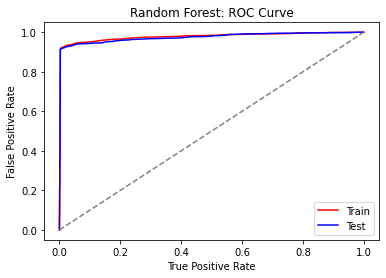

In [173]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = cvBestPipeline_rf.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.figure()
x_val = [x[0] for x in points_rfc]
y_val = [x[1] for x in points_rfc]
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Random Forest: ROC Curve')
plt.plot(roc['FPR'],roc['TPR'], label='Train', color='red')
plt.plot(x_val, y_val, label = 'Test', color='blue')
plt.plot([0, 1], [0, 1],'r--',color='grey')
plt.legend(loc=4)

In [177]:
# Calculate other metrics in addition to AUC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create Evaluator
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Get results from the prediction on the test set
predictionAndTarget = preds_rfc.select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})

print("RF CV acc: " + str(acc))
print("RF CV f1: " + str(f1))
print("RF CV weightedPrecision: " + str(weightedPrecision))
print("RF CV weightedRecall: " + str(weightedRecall))

RF CV acc: 0.9695185313474195
RF CV f1: 0.9691809470024564
RF CV weightedPrecision: 0.9704138601753767
RF CV weightedRecall: 0.9695185313474195


In [181]:
# Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

print("RF CV Confusion Matrix: ")
print(metrics.confusionMatrix().toArray())

RF CV Confusion Matrix: 
[[3852.  164.]
 [  12. 1746.]]


In [158]:
# Logistic Regresssion with 10-fold cross validation
# Use limited parameters for grid search as this takes time

lr = LogisticRegression()
pipeline = Pipeline().setStages([lr])

params = ParamGridBuilder()\
  .addGrid(lr.maxIter, [50, 100])\
  .build()

cv_lr = CrossValidator()\
  .setEstimator(pipeline)\
  .setEstimatorParamMaps(params)\
  .setEvaluator(evaluator)\
  .setNumFolds(10)

cvModel_lr = cv_lr.fit(train)

In [174]:
cvBestPipeline_lr = cvModel_lr.bestModel
cvBestLRModel = cvBestPipeline_lr.stages[-1]._java_obj.parent() #the stages function refers to the stage in the pipelinemodel

print("Best LR model:")
print("** MaxIter: " + str(cvBestLRModel.getMaxIter()))

Best LR model:
** MaxIter: 50


In [182]:
#Get predictions on the test set
preds_lr = cvModel_lr.transform(test)

In [183]:
print("LR CV Testing set areaUnderROC: " + str(evaluator.evaluate(preds_lr, {evaluator.metricName: "areaUnderROC"})))
print("LR CV Testing set areaUnderPR: " + str(evaluator.evaluate(preds_lr, {evaluator.metricName: "areaUnderPR"})))

LR CV Testing set areaUnderROC: 0.9745985902897469
LR CV Testing set areaUnderPR: 0.9714269353482489


In [184]:
# Returns as a list (false positive rate, true positive rate)
preds_lr_for_plot = preds_lr.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points_lr = CurveMetrics(preds_lr_for_plot).get_curve('roc')

In [206]:
cvBestPipeline_lr.stages

[LogisticRegressionModel: uid=LogisticRegression_0c6369289de1, numClasses=2, numFeatures=555]

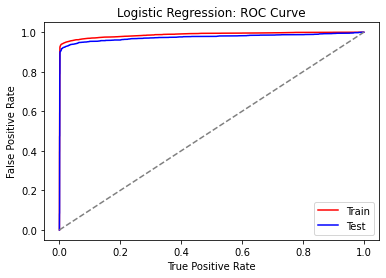

In [185]:
trainingSummary = cvBestPipeline_lr.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.figure()
x_val = [x[0] for x in points_lr]
y_val = [x[1] for x in points_lr]
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Logistic Regression: ROC Curve')
plt.plot(roc['FPR'],roc['TPR'], label='Train', color='red')
plt.plot(x_val, y_val, label = 'Test', color='blue')
plt.plot([0, 1], [0, 1],'r--',color='grey')
plt.legend(loc=4)

In [186]:
# Get results from the prediction on the test set
predictionAndTarget = preds_lr.select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})

print("LR CV acc: " + str(acc))
print("LR CV f1: " + str(f1))
print("LR CV weightedPrecision: " + str(weightedPrecision))
print("LR CV weightedRecall: " + str(weightedRecall))

LR CV acc: 0.9669206789054382
LR CV f1: 0.9666244202483707
LR CV weightedPrecision: 0.9673779340488506
LR CV weightedRecall: 0.9669206789054381


In [187]:
metrics = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

print("LR CV Confusion Matrix: ")
print(metrics.confusionMatrix().toArray())

LR CV Confusion Matrix: 
[[3831.  158.]
 [  33. 1752.]]


In [159]:
# Gradient Boosting with 10-fold cross validation
# Use limited parameters for grid search as this takes time

from pyspark.ml.classification import GBTClassifier

#Define pipeline
gb = GBTClassifier()
gb_pipeline = Pipeline().setStages([gb])

gbParams = ParamGridBuilder()\
  .addGrid(gb.maxDepth, [5, 10])\
  .build()

gbCv = CrossValidator()\
  .setEstimator(gb_pipeline)\
  .setEstimatorParamMaps(gbParams)\
  .setEvaluator(BinaryClassificationEvaluator())\
  .setNumFolds(10) 

gbModel = gbCv.fit(train)

In [190]:
cvBestPipeline_gb = gbModel.bestModel
cvBestGBModel = cvBestPipeline_gb.stages[-1]._java_obj.parent() #the stages function refers to the stage in the pipelinemodel

print("Best GB model:")
print("** MaxDepth: " + str(cvBestGBModel.getMaxDepth()))

Best GB model:
** MaxDepth: 10


In [191]:
#Get predictions on the test set
preds_gb = gbModel.transform(test)

In [192]:
print("GB CV Testing set areaUnderROC: " + str(evaluator.evaluate(preds_gb, {evaluator.metricName: "areaUnderROC"})))
print("GB CV Testing set areaUnderPR: " + str(evaluator.evaluate(preds_gb, {evaluator.metricName: "areaUnderPR"})))

GB CV Testing set areaUnderROC: 0.9793364443432723
GB CV Testing set areaUnderPR: 0.9744318794469241


In [200]:
ExtractFeatureImp(cvBestPipeline_gb.stages[-1].featureImportances, preds_gb, "features").head(20)

,idx,name,score
44,17,RestaurantsTakeOut_dum_True,0.819524
8,14,biz_review_count,0.035904
9,15,stars,0.018966
6,6,highlights_withText,0.008859
0,0,Call_To_Action_enabled,0.008158
43,16,RestaurantsTakeOut_dum_Missing,0.006313
27,545,total_tip_row,0.004378
1,1,Grubhub_enabled,0.004204
11,529,avg_stars,0.003784
7,13,is_open,0.003218


In [222]:
# Get results from the prediction on the test set
predictionAndTarget = preds_gb.select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})

print("GB CV acc: " + str(acc))
print("GB CV f1: " + str(f1))
print("GB CV weightedPrecision: " + str(weightedPrecision))
print("GB CV weightedRecall: " + str(weightedRecall))

GB CV acc: 0.9667474887426394
GB CV f1: 0.9665129410680298
GB CV weightedPrecision: 0.9669452220074346
GB CV weightedRecall: 0.9667474887426395


In [221]:
metrics = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

print("GB CV Confusion Matrix: ")
print(metrics.confusionMatrix().toArray())

GB CV Confusion Matrix: 
[[3818.  146.]
 [  46. 1764.]]


In [ ]:
# ---------------- End -----------------------------